In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [34]:
def score_classifier(dataset,
                     classifier,
                     labels,
                     nb_splits:int=3
                     ):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=nb_splits,
               random_state=50,
               shuffle=True
               )
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=nb_splits

    return confusion_mat, recall

In [35]:
from typing import Union, List
import re
import unidecode

def ts_slugify(ts : Union[str, pd.Series]):
    # slugify a pandas series or a string
    # remove special characters, accents and spaces
    # replace spaces by underscores
    # convert to lower case
    # it's a bit slow
    # TODO : use np.vectorize to make it faster
    if isinstance(ts, pd.Series):
        ts = ts.str.lower().str.replace(' ', '_')
        ts = ts.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        ts = ts.str.replace(pat="[^0-9A-z%_-]+", repl='', regex=True)
        ts = ts.str.replace(pat="['\\\\']", repl='', regex=True)
        return ts.str.strip('_')
    if isinstance(ts, str):
        string = ts.lower().replace(' ', '_')
        #replace % by percent
        string = string.replace('%', '_pca')
        string = unidecode.unidecode(string)
        string = re.sub('[^0-9A-z%_-]+', '', string)
        string = re.sub("['\\\\']", '', string)
        return string.strip('_')

In [36]:
!pwd

/Users/ramansheshka/code/test_datascience_mpdata/notebooks


## Data Overview

In [37]:
#parent directory
parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)


/Users/ramansheshka/code/test_datascience_mpdata


### Load the data

In [38]:
# Load dataset
df_raw = pd.read_csv(os.path.join(parent_dir,"data_test","nba_logreg.csv"))

In [39]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

### Data cleaning

i don't like the upper case in the column names, let's fix that

In [40]:
raw_columns_list = df_raw.columns.tolist()
print(raw_columns_list)
slug_columns_list = [ts_slugify(s) for s in raw_columns_list]
print(slug_columns_list)
#rename columns
df_raw.columns = slug_columns_list

['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs']
['name', 'gp', 'min', 'pts', 'fgm', 'fga', 'fg_pca', '3p_made', '3pa', '3p_pca', 'ftm', 'fta', 'ft_pca', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'target_5yrs']


In [41]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1340 non-null   object 
 1   gp           1340 non-null   int64  
 2   min          1340 non-null   float64
 3   pts          1340 non-null   float64
 4   fgm          1340 non-null   float64
 5   fga          1340 non-null   float64
 6   fg_pca       1340 non-null   float64
 7   3p_made      1340 non-null   float64
 8   3pa          1340 non-null   float64
 9   3p_pca       1329 non-null   float64
 10  ftm          1340 non-null   float64
 11  fta          1340 non-null   float64
 12  ft_pca       1340 non-null   float64
 13  oreb         1340 non-null   float64
 14  dreb         1340 non-null   float64
 15  reb          1340 non-null   float64
 16  ast          1340 non-null   float64
 17  stl          1340 non-null   float64
 18  blk          1340 non-null   float64
 19  tov   

It's a relatively small datase, only 1.5K rows, so no DL. i will be able to converge custom made regressor, havy fir asked problem. so pure ML.
Target is ```target_5yrs columns``` : takes 0 or 1, so classification problem.

In [42]:
df_raw.sample(5)

name  gp   min  pts  fgm  fga  fg_pca  3p_made  3pa  3p_pca  \
1175      Rodney Hood  50  21.3  8.7  3.1  7.5    41.4      1.2  3.4    36.5   
348   Lorenzo Charles  36   7.6  3.4  1.4  2.4    55.7      0.0  0.0     0.0   
844       Chris Quinn  42   9.7  3.4  1.1  3.1    36.6      0.5  1.4    35.1   
951      Richie Frahm  54   8.7  3.4  1.2  2.6    45.3      0.6  1.7    37.0   
1140   Alvin Williams  54  19.8  6.0  2.3  5.2    44.3      0.2  0.5    32.1   

      ...  fta  ft_pca  oreb  dreb  reb  ast  stl  blk  tov  target_5yrs  
1175  ...  1.6    76.3   0.2   2.2  2.3  1.7  0.6  0.2  0.9          0.0  
348   ...  1.0    66.7   0.4   0.7  1.1  0.2  0.1  0.2  0.5          0.0  
844   ...  0.9    67.6   0.1   0.6  0.7  1.5  0.4  0.0  0.5          1.0  
951   ...  0.5    88.5   0.2   0.8  1.0  0.4  0.3  0.1  0.1          0.0  
1140  ...  1.7    72.2   0.4   1.1  1.5  1.9  0.7  0.1  1.1          1.0  

[5 rows x 21 columns]

In [43]:
df_raw.describe()

gp          min          pts          fgm          fga  \
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000   
mean     60.414179    17.624627     6.801493     2.629104     5.885299   
std      17.433992     8.307964     4.357545     1.683555     3.593488   
min      11.000000     3.100000     0.700000     0.300000     0.800000   
25%      47.000000    10.875000     3.700000     1.400000     3.300000   
50%      63.000000    16.100000     5.550000     2.100000     4.800000   
75%      77.000000    22.900000     8.800000     3.400000     7.500000   
max      82.000000    40.900000    28.200000    10.200000    19.800000   

            fg_pca      3p_made          3pa       3p_pca          ftm  \
count  1340.000000  1340.000000  1340.000000  1329.000000  1340.000000   
mean     44.169403     0.247612     0.779179    19.308126     1.297687   
std       6.137679     0.383688     1.061847    16.022916     0.987246   
min      23.800000     0.000000     0.000000     0.000000     0.000000   
25%      40.200000     0.000000     0.000000     0.000000     0.600000   
50%      44.100000     0.100000     0.300000    22.400000     1.000000   
75%      47.900000     0.400000     1.200000    32.500000     1.600000   
max      73.700000     2.300000     6.500000   100.000000     7.700000   

               fta       ft_pca         oreb         dreb          reb  \
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000   
mean      1.821940    70.300299     1.009403     2.025746     3.034478   
std       1.322984    10.578479     0.777119     1.360008     2.057774   
min       0.000000     0.000000     0.000000     0.200000     0.300000   
25%       0.900000    64.700000     0.400000     1.000000     1.500000   
50%       1.500000    71.250000     0.800000     1.700000     2.500000   
75%       2.300000    77.600000     1.400000     2.600000     4.000000   
max      10.200000   100.000000     5.300000     9.600000    13.900000   

               ast          stl          blk          tov  target_5yrs  
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000  
mean      1.550522     0.618507     0.368582     1.193582     0.620149  
std       1.471169     0.409759     0.429049     0.722541     0.485531  
min       0.000000     0.000000     0.000000     0.100000     0.000000  
25%       0.600000     0.300000     0.100000     0.700000     0.000000  
50%       1.100000     0.500000     0.200000     1.000000     1.000000  
75%       2.000000     0.800000     0.500000     1.500000     1.000000  
max      10.600000     2.500000     3.900000     4.400000     1.000000

In [44]:
# duplicate rows
df_raw.duplicated().sum()

12

In [45]:
# show duplicated rows
df_raw[df_raw.duplicated(keep=False)].sort_values(by='name')

name  gp   min   pts  fgm   fga  fg_pca  3p_made  3pa  \
366      Charles Jones  78  20.1   8.4  3.0   5.8    52.0      0.0  0.1   
369      Charles Jones  29  16.4   3.7  1.3   4.2    31.7      0.7  2.1   
368      Charles Jones  29  16.4   3.7  1.3   4.2    31.7      0.7  2.1   
365      Charles Jones  78  20.1   8.4  3.0   5.8    52.0      0.0  0.1   
169      Charles Smith  34   8.6   3.5  1.4   3.7    39.2      0.4  1.4   
162      Charles Smith  60   8.7   2.9  1.0   2.2    44.4      0.0  0.1   
168      Charles Smith  34   8.6   3.5  1.4   3.7    39.2      0.4  1.4   
163      Charles Smith  60   8.7   2.9  1.0   2.2    44.4      0.0  0.1   
166      Charles Smith  71  30.4  16.3  6.1  12.4    49.5      0.0  0.0   
165      Charles Smith  71  30.4  16.3  6.1  12.4    49.5      0.0  0.0   
1335       Chris Smith  80  15.8   4.3  1.6   3.6    43.3      0.0  0.2   
1334       Chris Smith  80  15.8   4.3  1.6   3.6    43.3      0.0  0.2   
504      Eddie Johnson  74  20.5   9.3  4.0   8.7    45.9      0.0  0.1   
503      Eddie Johnson  74  20.5   9.3  4.0   8.7    45.9      0.0  0.1   
732   Gerald Henderson  43   8.3   2.6  0.9   2.4    35.6      0.1  0.4   
733   Gerald Henderson  43   8.3   2.6  0.9   2.4    35.6      0.1  0.4   
338        Ken Johnson  64  12.7   4.1  1.8   3.3    52.8      0.0  0.0   
339        Ken Johnson  64  12.7   4.1  1.8   3.3    52.8      0.0  0.0   
823    Marcus Williams  79  16.6   6.8  2.6   6.7    39.5      0.6  2.1   
824    Marcus Williams  79  16.6   6.8  2.6   6.7    39.5      0.6  2.1   
970      Mike Dunleavy  82  15.9   5.7  2.0   5.1    40.3      0.6  1.8   
971      Mike Dunleavy  82  15.9   5.7  2.0   5.1    40.3      0.6  1.8   
243    Reggie Williams  35  24.5  10.4  4.3  12.2    35.6      0.4  1.7   
242    Reggie Williams  35  24.5  10.4  4.3  12.2    35.6      0.4  1.7   

      3p_pca  ...  fta  ft_pca  oreb  dreb  reb  ast  stl  blk  tov  \
366      0.0  ...  3.6    64.8   1.8   3.3  5.1  1.6  0.6  0.8  1.8   
369     31.1  ...  0.8    50.0   0.3   1.1  1.4  1.4  0.6  0.2  1.0   
368     31.1  ...  0.8    50.0   0.3   1.1  1.4  1.4  0.6  0.2  1.0   
365      0.0  ...  3.6    64.8   1.8   3.3  5.1  1.6  0.6  0.8  1.8   
169     31.9  ...  0.3    54.5   0.4   0.4  0.8  0.6  0.3  0.2  0.8   
162      0.0  ...  1.3    69.7   0.2   0.9  1.2  1.7  0.6  0.1  0.6   
168     31.9  ...  0.3    54.5   0.4   0.4  0.8  0.6  0.3  0.2  0.8   
163      0.0  ...  1.3    69.7   0.2   0.9  1.2  1.7  0.6  0.1  0.6   
166      0.0  ...  5.5    72.5   2.4   4.1  6.5  1.5  1.0  1.3  2.1   
165      0.0  ...  5.5    72.5   2.4   4.1  6.5  1.5  1.0  1.3  2.1   
1335    14.3  ...  1.5    79.2   0.4   0.8  1.2  2.5  0.6  0.2  0.8   
1334    14.3  ...  1.5    79.2   0.4   0.8  1.2  2.5  0.6  0.2  0.8   
504      9.1  ...  2.0    66.4   1.7   2.6  4.4  1.5  0.7  0.2  1.3   
503      9.1  ...  2.0    66.4   1.7   2.6  4.4  1.5  0.7  0.2  1.3   
732     21.1  ...  1.1    74.5   0.3   0.9  1.3  0.3  0.2  0.2  0.3   
733     21.1  ...  1.1    74.5   0.3   0.9  1.3  0.3  0.2  0.2  0.3   
338      NaN  ...  1.3    43.5   1.4   2.4  3.8  0.3  0.2  0.3  0.9   
339      NaN  ...  1.3    43.5   1.4   2.4  3.8  0.3  0.2  0.3  0.9   
823     28.2  ...  1.1    84.7   0.4   1.7  2.1  3.3  0.4  0.0  1.8   
824     28.2  ...  1.1    84.7   0.4   1.7  2.1  3.3  0.4  0.0  1.8   
970     34.7  ...  1.2    78.0   0.8   1.8  2.6  1.3  0.7  0.2  1.1   
971     34.7  ...  1.2    78.0   0.8   1.8  2.6  1.3  0.7  0.2  1.1   
243     22.4  ...  1.9    72.7   1.6   1.8  3.4  1.7  0.8  0.6  1.8   
242     22.4  ...  1.9    72.7   1.6   1.8  3.4  1.7  0.8  0.6  1.8   

      target_5yrs  
366           0.0  
369           0.0  
368           0.0  
365           0.0  
169           1.0  
162           1.0  
168           1.0  
163           1.0  
166           1.0  
165           1.0  
1335          0.0  
1334          0.0  
504           1.0  
503           1.0  
732           1.0  
733           1.0  
338           0.0  
339   

In [46]:
# drop duplicates
df_raw.drop_duplicates(inplace=True)

In [47]:
df_raw[df_raw.duplicated(keep=False)].sort_values(by='name')

Empty DataFrame
Columns: [name, gp, min, pts, fgm, fga, fg_pca, 3p_made, 3pa, 3p_pca, ftm, fta, ft_pca, oreb, dreb, reb, ast, stl, blk, tov, target_5yrs]
Index: []

[0 rows x 21 columns]

In [48]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1328 non-null   object 
 1   gp           1328 non-null   int64  
 2   min          1328 non-null   float64
 3   pts          1328 non-null   float64
 4   fgm          1328 non-null   float64
 5   fga          1328 non-null   float64
 6   fg_pca       1328 non-null   float64
 7   3p_made      1328 non-null   float64
 8   3pa          1328 non-null   float64
 9   3p_pca       1318 non-null   float64
 10  ftm          1328 non-null   float64
 11  fta          1328 non-null   float64
 12  ft_pca       1328 non-null   float64
 13  oreb         1328 non-null   float64
 14  dreb         1328 non-null   float64
 15  reb          1328 non-null   float64
 16  ast          1328 non-null   float64
 17  stl          1328 non-null   float64
 18  blk          1328 non-null   float64
 19  tov   

In [49]:
#nan values
df_raw.isna().sum()

name            0
gp              0
min             0
pts             0
fgm             0
fga             0
fg_pca          0
3p_made         0
3pa             0
3p_pca         10
ftm             0
fta             0
ft_pca          0
oreb            0
dreb            0
reb             0
ast             0
stl             0
blk             0
tov             0
target_5yrs     0
dtype: int64

In [51]:
# let's see the rows with nan values
df_raw[df_raw.isna().any(axis=1)]

name  gp   min   pts  fgm  fga  fg_pca  3p_made  3pa  3p_pca  \
338     Ken Johnson  64  12.7   4.1  1.8  3.3    52.8      0.0  0.0     NaN   
340   Pete Williams  53  10.8   2.8  1.3  2.1    60.4      0.0  0.0     NaN   
358   Melvin Turpin  79  24.7  10.6  4.6  9.0    51.1      0.0  0.0     NaN   
386    Jim Petersen  60  11.9   3.2  1.2  2.4    48.6      0.0  0.0     NaN   
397   Tom Scheffler  39   6.9   1.3  0.5  1.3    41.2      0.0  0.0     NaN   
507    Sam Williams  59  18.2   6.1  2.6  4.7    55.6      0.0  0.0     NaN   
509   Kurt Nimphius  63  17.2   5.3  2.2  4.7    46.1      0.0  0.0     NaN   
510  Pete Verhoeven  71  17.0   4.9  2.1  4.2    50.3      0.0  0.0     NaN   
521       Jim Smith  72  11.9   2.9  1.2  2.3    50.9      0.0  0.0     NaN   
559    Jeff Wilkins  56  18.9   4.7  2.1  4.6    45.0      0.0  0.0     NaN   

     ...  fta  ft_pca  oreb  dreb  reb  ast  stl  blk  tov  target_5yrs  
338  ...  1.3    43.5   1.4   2.4  3.8  0.3  0.2  0.3  0.9          0.0  
340  ...  0.8    42.5   0.9   1.9  2.8  0.3  0.4  0.4  0.4          0.0  
358  ...  1.8    78.4   2.0   3.8  5.7  0.5  0.5  1.1  1.5          1.0  
386  ...  1.1    75.8   0.7   1.7  2.5  0.5  0.2  0.5  1.2          1.0  
397  ...  0.5    50.0   0.5   1.5  1.9  0.3  0.2  0.3  0.4          0.0  
507  ...  1.5    55.1   1.5   3.7  5.2  0.6  0.8  1.3  1.1          0.0  
509  ...  1.7    58.3   1.5   3.2  4.7  1.0  0.3  1.3  0.9          1.0  
510  ...  1.0    70.8   1.5   2.1  3.6  0.7  0.6  0.3  0.8          1.0  
521  ...  1.2    45.9   1.0   1.5  2.5  0.6  0.3  0.7  0.7          0.0  
559  ...  0.7    67.5   1.1   3.8  4.9  0.7  0.6  0.8  1.1          1.0  

[10 rows x 21 columns]

### let's remplace nan values by the mean of the column rp_pca

In [52]:
# replacing Nan values (only present when no 3 points attempts have been performed by a player)
column_name = '3p_pca'
array = df_raw[column_name].values
array_clean = np.nan_to_num(array,
                            nan=0.0
                            )
df_clean = df_raw.copy()
df_clean[column_name] = array_clean
#for x in np.argwhere(np.isnan(df_vals)):
#    df_vals[x]=0.0

## Data exploration

In [53]:
all_features = df_raw.columns.tolist()
all_features.remove('name')
all_features.remove('target_5yrs')
print(all_features)
df_clean.groupby(by=['target_5yrs'])[all_features].mean()

['gp', 'min', 'pts', 'fgm', 'fga', 'fg_pca', '3p_made', '3pa', '3p_pca', 'ftm', 'fta', 'ft_pca', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov']


gp        min       pts       fgm       fga     fg_pca  \
target_5yrs                                                                  
0.0          51.434524  14.231746  5.038690  1.945040  4.540278  42.374206   
1.0          65.901699  19.715655  7.884102  3.049393  6.708374  45.291990   

              3p_made       3pa     3p_pca       ftm       fta     ft_pca  \
target_5yrs                                                                 
0.0          0.229365  0.753175  19.193651  0.921825  1.318254  68.902381   
1.0          0.258981  0.794296  19.167597  1.528277  2.130340  71.195510   

                 oreb      dreb       reb       ast       stl       blk  \
target_5yrs                                                               
0.0          0.716865  1.527976  2.242857  1.215079  0.498413  0.252976   
1.0          1.188835  2.333252  3.521845  1.756796  0.692840  0.439442   

                  tov  
target_5yrs            
0.0          0.939087  
1.0          1.349272

In [54]:
import seaborn as sns

sns.pairplot(df_clean,
             hue='target_5yrs',
             diag_kind='kde',
             corner=True,
             )

In [55]:
#correlation matrix
corr_array = df_clean[all_features].corr()

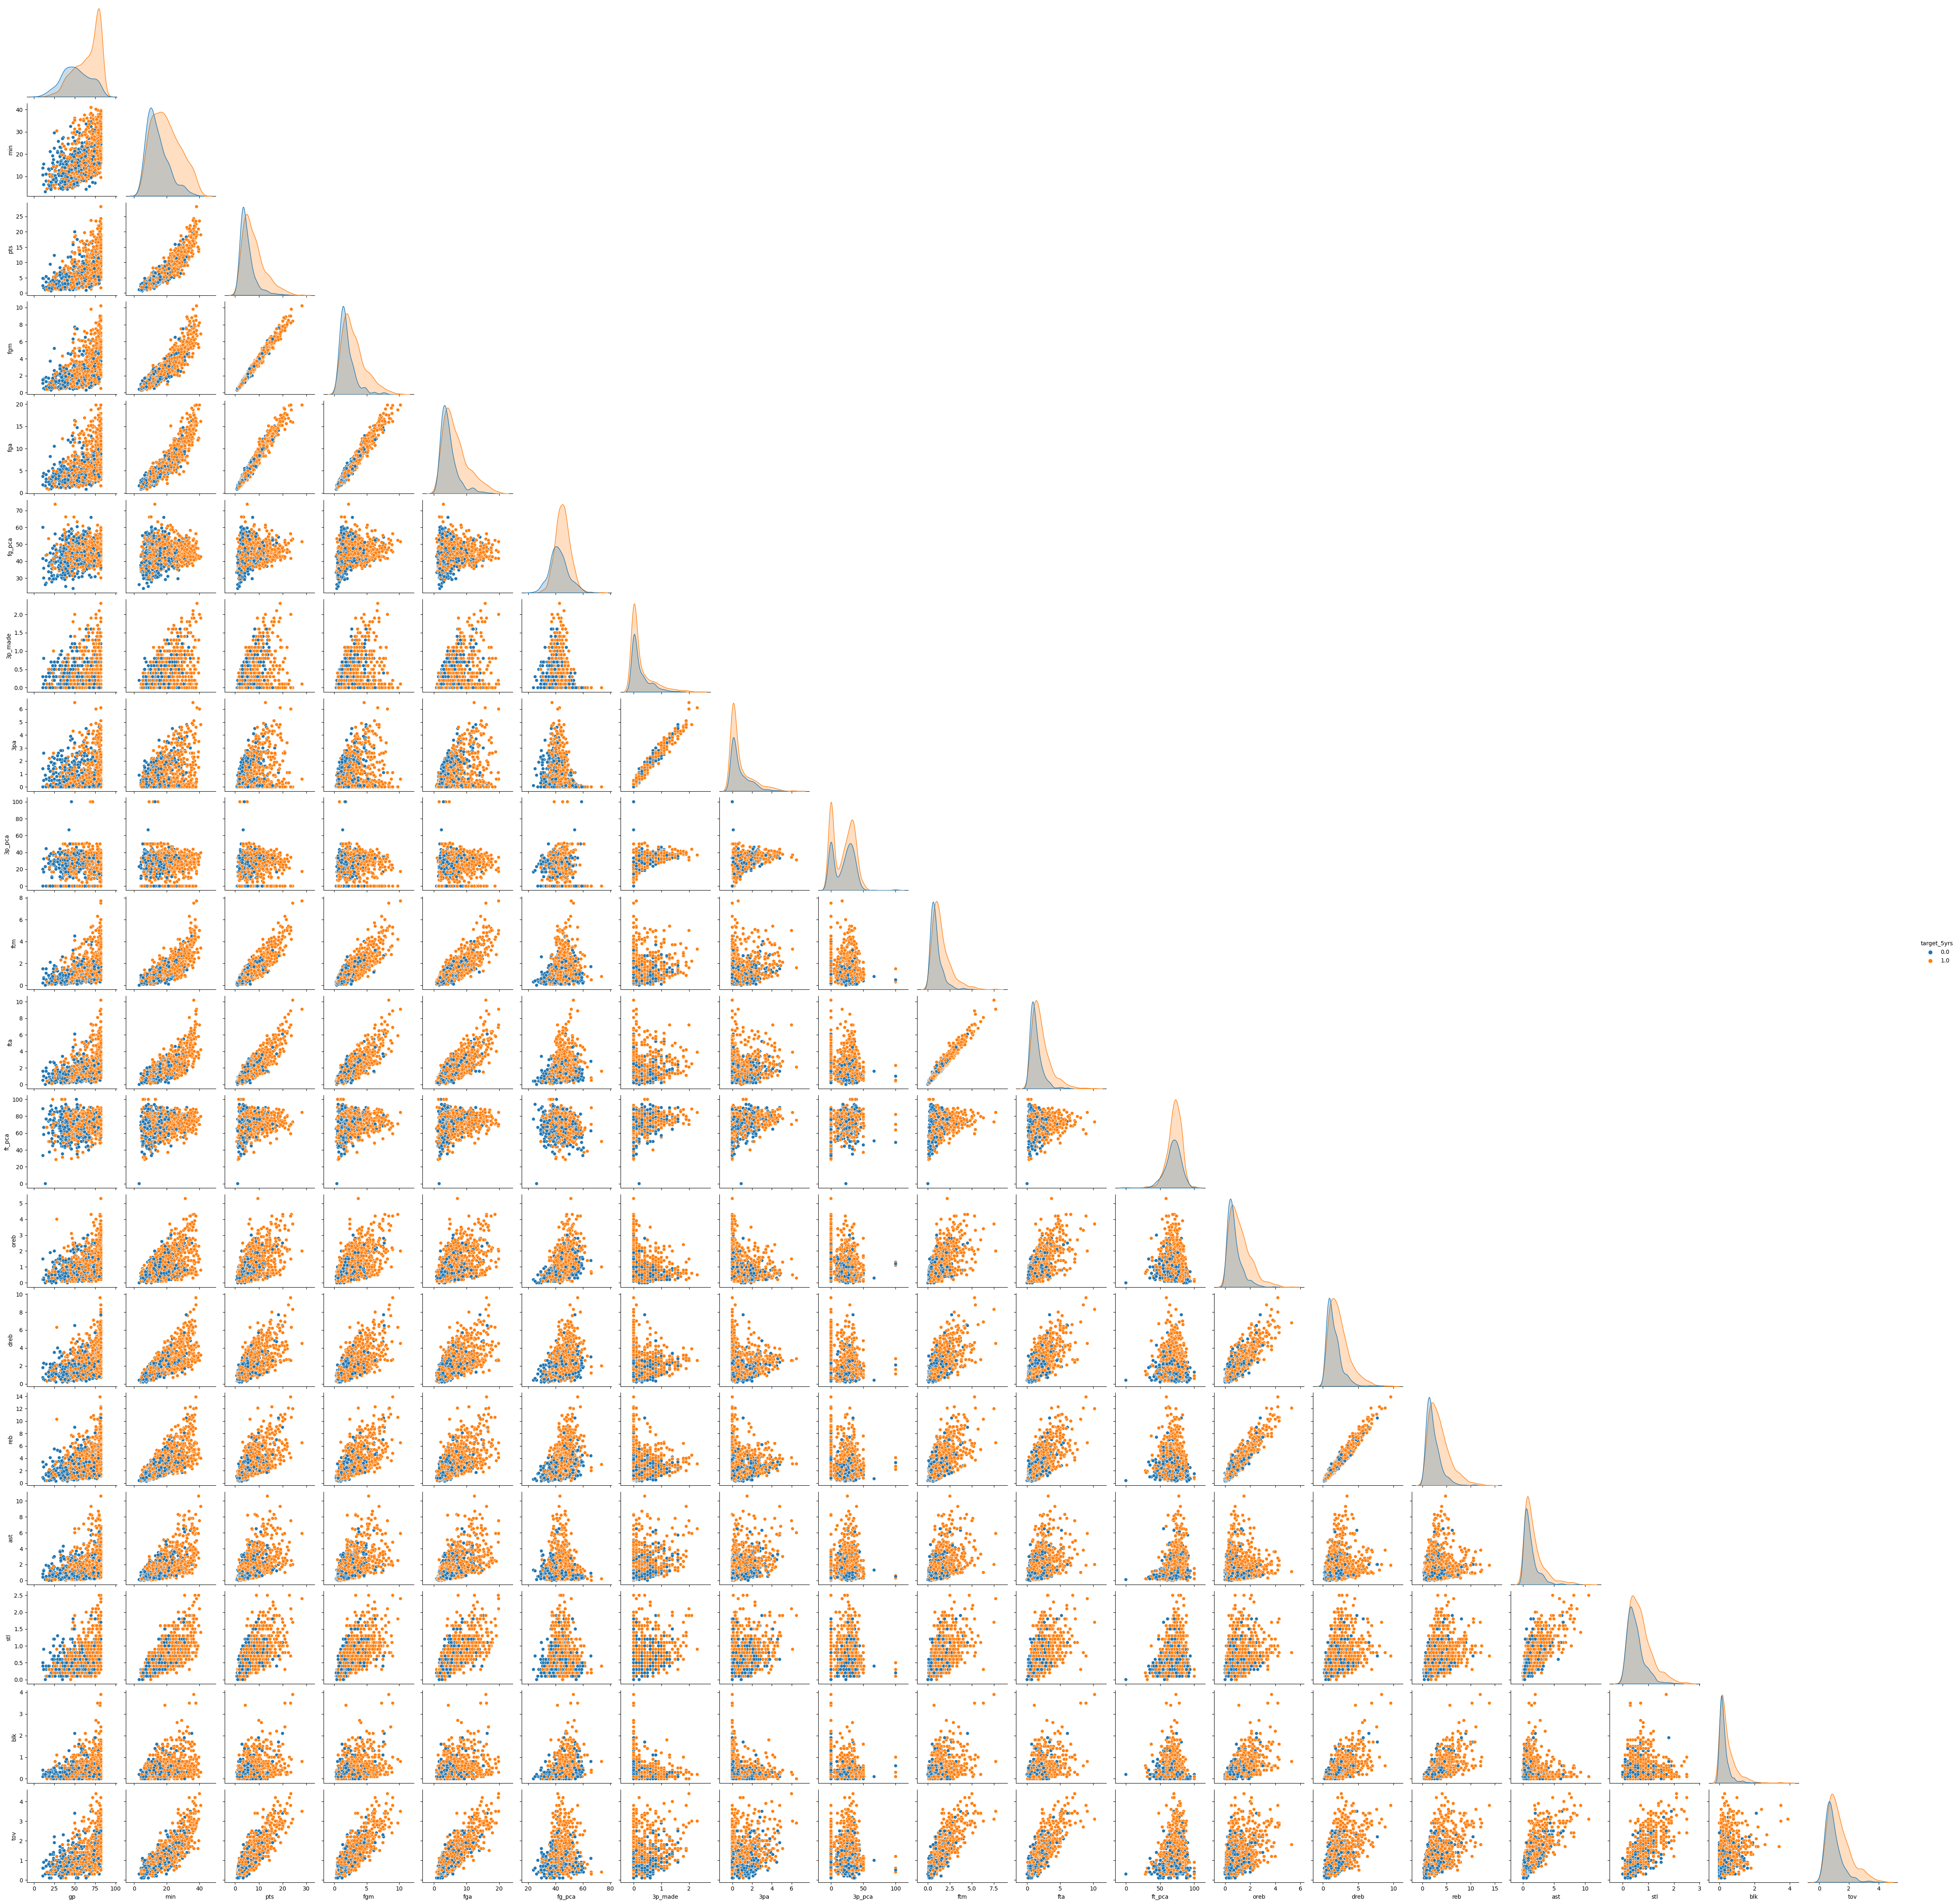

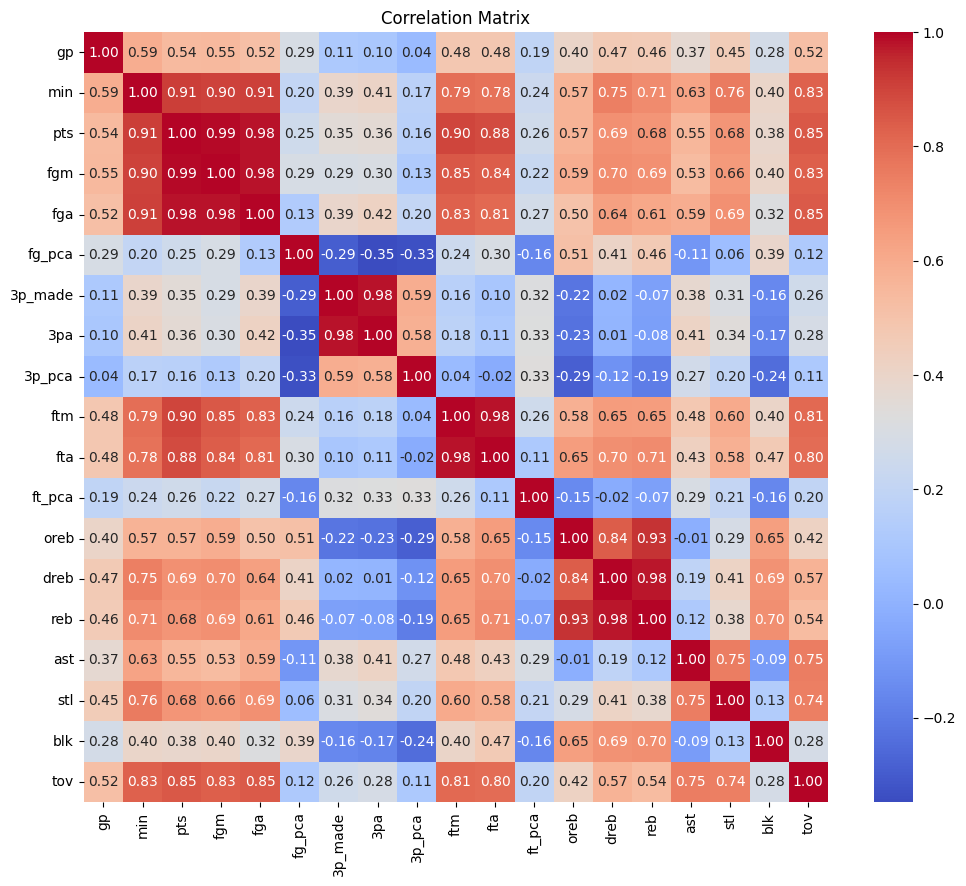

In [56]:
# visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_array,
            annot=True,
            cmap='coolwarm',
            fmt=".2f"
            )
plt.title("Correlation Matrix")
plt.show()

1.0    824
0.0    504
Name: target_5yrs, dtype: int64

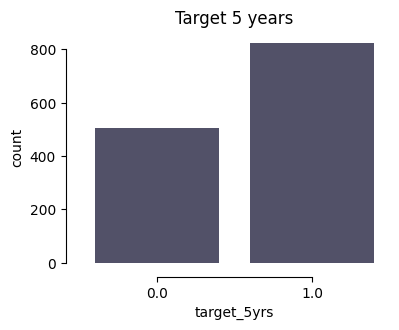

In [64]:
display(df_clean['target_5yrs'].value_counts())

# bar plot of target_5yrs
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x='target_5yrs',
              data=df_clean,
              color = "#03012d",
              alpha = 0.7,
              ax=ax
              )
sns.despine(offset=10,
            trim=True,
            ax=ax
            )
ax.set_title('Target 5 years')
plt.show()

## retroengineering

In [65]:
df_clean.columns

Index(['name', 'gp', 'min', 'pts', 'fgm', 'fga', 'fg_pca', '3p_made', '3pa',
       '3p_pca', 'ftm', 'fta', 'ft_pca', 'oreb', 'dreb', 'reb', 'ast', 'stl',
       'blk', 'tov', 'target_5yrs'],
      dtype='object')

In [ ]:
df_clean

## Modelisation

In [66]:
df = df_clean.copy()

### build the dataset

In [86]:
# extract names, labels, features names and values
names = df['name'].values.tolist() # players names
labels = df['target_5yrs'].values # labels
paramset = df.drop(['target_5yrs','name'],axis=1).columns.values
df_vals = df.drop(['target_5yrs','name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
#for x in np.argwhere(np.isnan(df_vals)):
#    df_vals[x]=0.0

# normalize dataset
X = MinMaxScaler().fit_transform(df_vals)
y = labels

### baseline model

In [ ]:
#example of scoring with support vector classifier
base_estimator = SVC()
model_confusion_matrix,model_recal = score_classifier(X,
                                                      base_estimator,
                                                      y
                                                      )

print(model_confusion_matrix)
print(model_recal)
#from sklearn.metrics import ConfusionMatrixDisplay


[[270. 234.]
 [142. 682.]]
0.8274446177323874


In [88]:
estimator = RandomForestClassifier(n_estimators=100,
                                   random_state=42
                                   )
model_confusion_matrix,model_recal = score_classifier(X,
                                                      estimator,
                                                      y
                                                      )

print(model_confusion_matrix)
print(model_recal)

[[276. 228.]
 [174. 650.]]
0.788682899833979


In [89]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [90]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [ ]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 5,
    "verbose": -1,
    "max_depth": 5,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test],
)

In [92]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

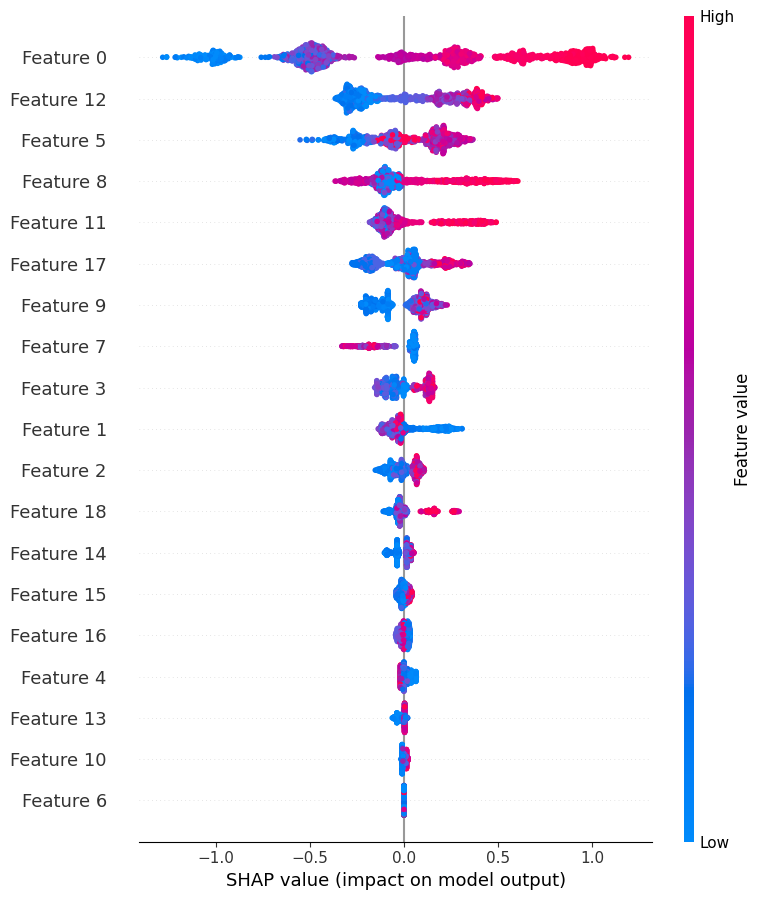

In [93]:
shap.summary_plot(shap_values, X)